In [5]:
import numpy as np
norm = np.linalg.norm
sqrt = np.math.sqrt
dot = np.dot
array = np.array
from scipy.spatial.transform import Rotation
import scipy.ndimage
import pandas as pd
import os

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors

In [6]:
from multiprocessing.pool import ThreadPool

In [20]:
class Segmentation:
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)
        if "theta" in kwargs:
            self.set_angle(kwargs["theta"])
        else:
            raise ValueError("Diffraction angle missing.")
            
    def set_angle(self, angle, degrees=True):
        if np.isclose(angle, 45.0):
            self.m = np.infty
            self.n = array([1,0])
        else:
            self.m = np.tan(angle*np.pi/90)
            self.n = array([1, -1.0/self.m])/norm(array([1, -1.0/self.m]))
        self.rot_mat = Rotation.from_euler("z", 180-2*angle, degrees=degrees).as_matrix()[:2,:2]

    def coord(step, a, b, dim):
        return a + step*(b-a)/(dim-1)

    def coord2idx(self, x, a, b, dim, decimals=0):
        """Turn coordinates into indices"""
        return np.around(((x-a) * (dim-1)/(b-a)), decimals=decimals).astype(int)   
    
    def rot(self, x, origin, angle=None, degrees=True):
        if angle is not None:
            rot_mat = Rotation.from_euler("z", 180-2*angle, degrees=degrees).as_matrix()[:2,:2]
        return origin + (x-origin) @ self.rot_mat
    
    def rotate(self, array, angle=None):
        if angle is None:
            angle = self.theta
        #scipy.ndimage.rotate(array, -180+2*angle, reshape=False)
        return np.matmul(array, seg.rot_mat)
    
    def gen_coords(self, a, b, dim, dtype=np.float64):
        X = np.linspace(a, b, dim, dtype=np.float64)
        Y = np.linspace(a, b, dim, dtype=np.float64)
        return array(np.meshgrid(X, Y, indexing="ij"), dtype=np.float64).swapaxes(0,2)
        
    def gen_coords_old(self, a, b, dim, dtype=np.float64):
        #X = np.linspace(a, b, dim, dtype=np.float64)
        #Y = np.linspace(a, b, dim, dtype=np.float64)
        #return array(np.meshgrid(X, Y, indexing="ij"), dtype=np.float64).swapaxes(0,2)
        
        return array([[[Segmentation.coord(i, a, b, dim), Segmentation.coord(j, a, b, dim)] for i in range(dim)] for j in range(dim)], dtype=dtype)

    def intersectDR(self, x, radius, right=True):
        ray_0 = dot([-self.m, 1], x)
        c = dot(self.n, x)
        return dot(self.n, array([c, ((-1)**right)*sqrt(radius**2 - c**2)]))*array([1, self.m]) + array([0, ray_0])

    def intersectER(self, x, radius, right=True):
        return array([(-1)**int(not right)*sqrt(radius**2 - x[1]**2), x[1]])

    def dist(self, x, total=False, case=1):
        """
        Computes travel distance of ray through medium with diffraction point in x
        """
        if case==1:
            # case A_{s,sc}
            return self.dist_F1(x, total=total)
        elif case==2:
            # case A_{c,sc}
            if np.isinf(self.m):
                return self.dist_F2_90(x, total=total)
            return self.dist_F2(x, total=total)
        elif case==3:
            # case A_{c,c}
            return self.dist_F3(x, total=total)
        else:
            return None
        
    def dist90(self, x, total=False, case=1):
        """
        Computes travel distance of ray through medium with diffraction point in x
        """
        if case==1:
            # case A_{s,sc}
            return self.dist_F1_90(x, total=total)
        elif case==2:
            # case A_{c,sc}
            return self.dist_F2_90(x, total=total)
        elif case==3:
            # case A_{c,c}
            return self.dist_F3_90(x, total=total)
        else:
            return None
    
    def dist_F1(self, x, total=False):
        """
        REN = ray entry point
        REX = ray exit point
        
        (case A_{s,sc})
        """

        # 1
        d_cell, d_sample = 0.0, 0.0
        # 2
        if norm(x) <= self.r_sample:
            REN_outer = self.intersectER(x, self.r_cell, right=0)
            REN_inner = self.intersectER(x, self.r_sample, right=0)
            
            d_sample = norm(x - REN_inner)
            d_cell = norm(REN_inner - REN_outer)
                
        if total:
            return d_cell, d_sample, d_cell+d_sample
        return d_cell, d_sample

    def dist_F1_90(self, x, total=False):
        """(case A_{s,sc})"""

        # 1
        d_cell, d_sample = 0.0, 0.0
        # 2
        if norm(x) <= self.r_sample:
            REN_g1o = self.intersectER(x, self.r_cell, right=0)
            REN_g1i = self.intersectER(x, self.r_sample, right=0)
            
            d_sample = norm(x - REN_g1i)
            d_cell = norm(REN_g1i - REN_g1o)
                
        if total:
            return d_cell, d_sample, d_cell+d_sample
        return d_cell, d_sample
    
    def dist_F2(self, x, total=False): 
        """(case A_{c,sc})"""
        
        # 1
        d_cell, d_sample = 0.0, 0.0
        # 2
        if self.r_sample < norm(x) <= self.r_cell:
            REN_g1o = self.intersectER(x, self.r_cell, right=0)
            
            if (x[0] >= 0 and abs(x[1]) < self.r_sample): # right of sample and ER intersection
                REN_g1i = self.intersectER(x, self.r_sample, right=0)
                REX_g1i = self.intersectER(x, self.r_sample)
                d_cell = norm(REN_g1o - REN_g1i) + norm(REX_g1i - x)
                d_sample = norm(REN_g1i - REX_g1i)

            else: # left of sample or no ER sample intersection
                d_cell = norm(REN_g1o - x)
                d_sample = 0.0
            
        if total:
            return d_cell, d_sample, d_cell+d_sample
        return d_cell, d_sample

    def dist_F2_90(self, x, total=False):
        """(case A_{c,sc}) when theta=45°."""
        return self.dist_F2(x, total=total)
    
    def dist_F3(self, x, total=False): 
        """(case A_{c,c})"""
        d_cell, d_sample = self.dist_F2(x)
        if total:
            return d_cell, 0, d_cell
        else:
            return d_cell, 0

    def dist_F3_90(self, x, total=False): 
        """(case A_{c,c})"""
        d_cell, d_sample = self.dist_F2_90(x)
        if total:
            return d_cell, 0, d_cell
        else:
            return d_cell, 0
            
    def get_g1_dists(self, resolution, margin=1.2, total=False, case=1, coords=None):
        if coords is None:
            coords = self.gen_coords(-self.r_cell*margin, self.r_cell*margin, dim=resolution)
        if np.isinf(self.m):
            return np.apply_along_axis(self.dist90, 2, coords, total=total, case=case)
        return np.apply_along_axis(self.dist, 2, coords, total=total, case=case)
    
    def g2_from_g1(self, idx, source):
        if np.any(idx >= source.shape[:2]) or np.any(idx < 0):
            return np.zeros(source.shape[-1])
        return source[tuple(idx)]
    
    def get_g2_dists(self, resolution, margin=1.2, total=False, case=1, coords=None, g1_dists=None):
        if coords is None:
            coords = self.gen_coords(-self.r_cell*margin, self.r_cell*margin, dim=resolution)
        #if g1_dists is None:
        #    g1_dists = self.get_g1_dists(resolution, margin, total, case, coords)
        if coords.shape[0] != g1_dists.shape[0]:
            raise ValueError("Coordinate shape does not match distances shape.")
        coords_rotated = self.rotate(coords)
        #np.apply_along_axis(self.rot, 2, coords, origin=array([0,0]))
        #indices_rotated = np.apply_along_axis(self.coord2idx, 2, coords_rotated, 
        #    -self.r_cell*margin, self.r_cell*margin, dim=resolution)

        #g2_dists = np.apply_along_axis(self.g2_from_g1, 2, indices_rotated, source=g1_dists)
        g2_dists = self.get_g1_dists(resolution, margin, total, case, coords=coords_rotated)
        
        return g2_dists
    
    def get_dists(self, resolution, margin=1.2, total=False, case=1, coords=None, g1_dists=None):
        if g1_dists is None:
            g1_dists = self.get_g1_dists(resolution, 
                margin=margin, total=total, case=case, coords=coords)
        g2_dists = self.get_g2_dists(resolution, 
            margin=margin, total=total, 
            case=case, coords=coords, g1_dists=g1_dists)
        return g1_dists+g2_dists
    
    def scale_to(self, outer):
        """Scale distances by difference in radii."""
        pass

    def step_angle(self, angles, resolution=80, margin=1.2, cases=[1,2,3], coords=None, pbar=None):
        factors = np.zeros(shape=(len(angles), len(cases)))
        g1_dists = array([self.get_g1_dists(resolution, margin=margin, case=case, coords=coords) 
                    for case in cases])
        
        
        for i in range(len(angles)):
            for case in cases:
                self.set_angle(angles[i])
                distances = self.get_dists(
                    resolution, margin=margin, case=case, coords=coords, g1_dists=g1_dists[case-1])
                factors[i,case-1] = self.get_absorptionfactor(distances, self.mu, case=case)
            pbar.update(1)
        return factors    
    
    def plot_dists(self, resolution, margin=1.2, total=False, cmap=None, distances=None):
        if distances is None:
            distances = self.get_dists(resolution, margin=margin, total=total)
        
        titles = ["Cell", "Sample", "Total"]
        fig, axes = plt.subplots(ncols=distances.shape[2], figsize=(16,10), gridspec_kw={'width_ratios': [1]*distances.shape[2]})
        for i in range(distances.shape[2]):
            im = axes[i].imshow(distances[:,:,i], 
                        cmap=cmap, interpolation='none', 
                        origin="lower",
                        extent=[-self.r_cell*margin,self.r_cell*margin]*2,
                        vmin=distances.min(), vmax=distances.max()
                    )
            axes[i].set_title(titles[i] + " distances")
        
        if cmap is None:
            cmp = plt.cm.get_cmap("viridis", 10)
        cmp.set_bad(color='red')
        cmp.set_under(color="black")
        fig.colorbar(im, ax=axes, orientation='horizontal', fraction=.1, aspect=30, pad=0.1)
        return axes
    
    def plot_absorbfactors(self, angles=np.linspace(1.0,90,5), resolution=80, margin=1.2, figsize=(18,4), pbar=None):
        angle_absorptions = self.get_absorptionfactors(angles, resolution=resolution, margin=margin, pbar=pbar)

        fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True)
        st = fig.suptitle(f"Absorptions for angles [{angles.min()},...,{angles.max()}]", fontsize=14)
        st.set_y(1.04)

        case_strings = ["A_{s,sc}", "A_{c,sc}", "A_{c,c}"]
        colors = ["violet", "orange", "red"]
        for i in range(3):
            axs[i].plot(angles, angle_absorptions[:,i], color=colors[i])
            axs[i].set_title(f"{case_strings[i]}")

        return fig,axs 
    
    def get_absorptionfactors(self, angles=np.linspace(1.0,90,5), resolution=80, margin=1.2, pbar=None):
        if pbar is None:
            pbar = tqdm(total=angles.size)
        coords = self.gen_coords(-self.r_cell*margin, self.r_cell*margin, dim=resolution)
        angle_absorptions = self.step_angle(angles, resolution=resolution, coords=coords, margin=margin, pbar=pbar)
        return angle_absorptions

    def get_absorptions(self, mu, distances):
        return np.apply_along_axis(lambda x: np.exp(-np.dot(mu, x)), 2, distances)
    
    def save_absorptionfactors(self, path, factors, angles, float_format="%.3f"):
        df = pd.DataFrame(absorptions, index=angles, columns=["A_{s,sc}", "A_{c,sc}", "A_{c,c}"])
        df.index.name = "2 theta"
        df.index = df.index.map(lambda x: float_format % x)
        df.to_csv(path)
    
    def get_absorptionfactor(self, distances, mu, case=None):
        if case is None:
            case_mask = [1,1]
        else:
            case_mask = [[1,1], [1,1], [1,0]][case-1]
        absorptions = self.get_absorptions(case_mask*mu, distances)
        return np.sum(absorptions[absorptions!=1])/absorptions[absorptions!=1].shape[0]

In [8]:
config = {
    "seg" : {
        "theta" : 45.0,
        "r_cell" : 1.5,
        "r_sample" : 1.0,
        "mu" : array([.54747*1E-1, 6.70333*1E-1]),  # cell, sample.
    },
    "det" : {
        "shape" : array([512, 512]), # pixel count on each axis.
        "distance" : 240.18,    # [mm] distance from centerpoint x_0 of medium to projection point p_0 on detector plane.
        "offsets" : array([4.6, 4.3, 0.0]), # [mm,mm,mm] offsets from p_0 to origin point on detector plane. Origin=lower right.
        "pixelsize" : array([200*1E-3, 200*1E-3]) # [mm,mm] size of each pixel on detector.
    }
}

In [9]:
seg = Segmentation(**config["seg"])

In [785]:
%%timeit -n 5
seg.gen_coords_old(-1.5*1.05, 1.5*1.05, 512)

183 ms ± 736 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [786]:
%%timeit -n 5
seg.gen_coords(-1.5*1.05, 1.5*1.05, 512)

2.78 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [882]:
%%timeit -n 5
Detector(**config["det"])

3.91 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [26]:
class Detector:
    """
    Detector is on XY-plane, with z=0. 
    Every segment point has distance
    """
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)
        self.plane_det = self.gen_coords()
    
    def gen_coords(self):
        X = np.linspace(self.pixelsize[0]*self.shape[0], 0, self.shape[0], dtype=np.float64)
        Y = np.linspace(self.pixelsize[1]*self.shape[1], 0, self.shape[1], dtype=np.float64)
        plane_coords = array(np.meshgrid(X, Y, indexing="ij"), dtype=np.float64).swapaxes(0,2)
        return np.insert(plane_coords, 2, 0, axis=2)
        
    def translate_segments(self, segment_coords):
        """
        Translate segment 2D space into detector 3D space.
        """
        # Put segment coordinates from segment space axes X,Y on detector space axes Z,X:
        plane_seg = np.zeros(array(segment_coords.shape)+array([0,0,1])) # expand segment space to 3D
        plane_seg[:,:,0] = segment_coords[:,:,1] + self.offsets[0]       # axis swap Y -> X. Add X-offset.
        plane_seg[:,:,1] = self.offsets[1]                               # add Y-offset.
        plane_seg[:,:,2] = segment_coords[:,:,0] + self.distance         # axis swap X -> Z. Add detector distance.
        return plane_seg

    def translate_segments_inv(self, det_coords):
        return det_coords - array([self.offsets[0], self.offsets[1], self.distance])
    
    def projection(self, segment_plane):
        """Project coordinates of segment onto plane. (intersection point of g1 and plane)"""
        projections = segment_plane
        projections[:,:,2] = 0
        
    def project_Y(self):
        projection = self.plane_det
        projection[:,:,1] = 0
        return projection
    
    def precompute_trig(self):
        # angles_theta on X-axis, repeat on Y-axis.
        # (b) distances on XZ-plane, repeat on Y-axis
        # (c) distances on YZ-plane, repeat  on X-axis.
        
        self.trig = np.zeros(self.plane_det)     # array with vectors (theta, b_dist, c_dist)
        self.trig[:,:,1] = norm(self.project_Y() - array[self.offsets[0], self.offsets[1], self.distance], axis=2)
        self.trig[:,:,0] = np.apply_along_axis(np.arctan2, 2, self.trig[:,:,1]/self.distance)
        self.trig[:,:,2] = norm(self.plane_det - array[self.offsets[0], self.offsets[1], self.distance], axis=2)
    
    def travel_dist(x, resolution, margin, coords):
        """
        Fixpoint in theta, iterate over alpha angles.
        """
        g2_dists = seg.get_g2_dists(resolution=resolution, margin=margin, coords=coords)    # g2_dists from theta 
        g2_dists = np.insert(g2_dists, 2, 0, axis=2)[:,:,[1,2,0]]        # translation into 3D detector space.
        
        # TODO:
        # for each point in detector:
            # calculate b/c = cos(alpha).
            # expand 2D g2_dists to 3D g2_dists by stretching g2_dist with cos(alpha)
        pass
    
    def travel_dists(self):
        # call travel_dist
        pass

In [25]:
np.arctan2(np.arange(0,5,10), np.arange(-3,-2,10))

array([3.14159265])

In [1134]:
det = Detector(**config["det"])

In [1135]:
coords = seg.gen_coords(-seg.r_cell*1.05, seg.r_cell*1.05, 512)

In [1119]:
def array_info(arr):
    return array([
        ["Min", arr.min(axis=(0,1))],
        ["Max", arr.max(axis=(0,1))],
    ])

In [1137]:
# Proof that translation is bijection.
det.translate_segments_inv(det.translate_segments(coords))

array([[[-1.575     ,  0.        , -1.575     ],
        [-1.575     ,  0.        , -1.56883562],
        [-1.575     ,  0.        , -1.56267123],
        ...,
        [-1.575     ,  0.        ,  1.56267123],
        [-1.575     ,  0.        ,  1.56883562],
        [-1.575     ,  0.        ,  1.575     ]],

       [[-1.56883562,  0.        , -1.575     ],
        [-1.56883562,  0.        , -1.56883562],
        [-1.56883562,  0.        , -1.56267123],
        ...,
        [-1.56883562,  0.        ,  1.56267123],
        [-1.56883562,  0.        ,  1.56883562],
        [-1.56883562,  0.        ,  1.575     ]],

       [[-1.56267123,  0.        , -1.575     ],
        [-1.56267123,  0.        , -1.56883562],
        [-1.56267123,  0.        , -1.56267123],
        ...,
        [-1.56267123,  0.        ,  1.56267123],
        [-1.56267123,  0.        ,  1.56883562],
        [-1.56267123,  0.        ,  1.575     ]],

       ...,

       [[ 1.56267123,  0.        , -1.575     ],
        [ 1

In [1127]:
segment_plane = det.translate_segments(det.plane_det)

In [ ]:
world_plane = 

In [1128]:
(segment_plane - det.offsets)[:,:,2].max()

ValueError: operands could not be broadcast together with shapes (512,512,4) (3,) 

<IPython.core.display.Javascript object>


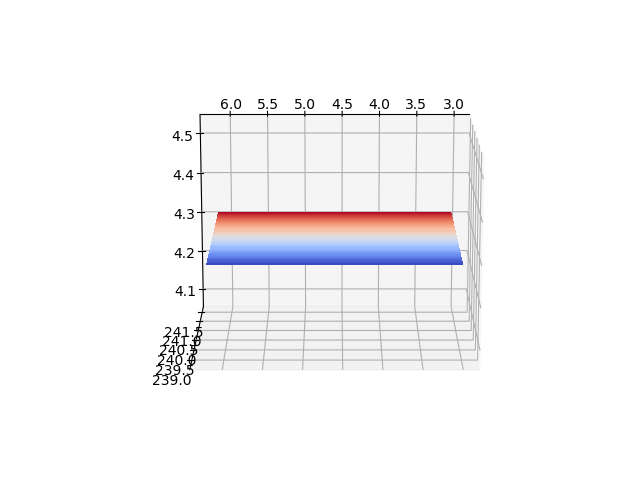

In [1024]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(
    segment_plane[:,:,0], 
    segment_plane[:,:,1],
    #np.ones(segment_plane.shape)[:,:,0],
    segment_plane[:,:,2]+norm(segment_plane[:,:,:2], axis=2), 
    cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)

ax.view_init(-75, 90)
plt.draw()

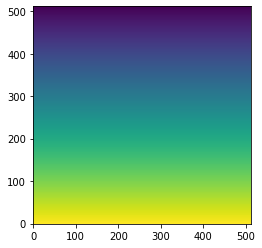

In [899]:
plt.imshow(det.plane_coords[:,:,1], origin="lower")

In [910]:
pl = det.plane_coords

In [962]:
len(pl[pl[:,:,1]<det.offsets[1]])/pl.size

0.014322916666666666

TypeError: Invalid shape (265216,) for image data

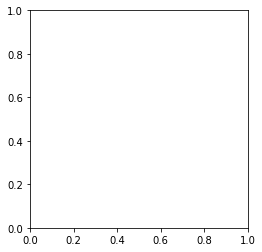

In [900]:
plt.imshow(det.plane_coords[(det.plane_coords<0.5)])

In [805]:
np.insert(det.plane_coords, 2, 0, axis=2)

array([[[2.04800000e+05, 2.04800000e+05, 0.00000000e+00],
        [2.04800000e+05, 2.04800000e+05, 0.00000000e+00],
        [2.04599804e+05, 2.04800000e+05, 0.00000000e+00],
        ...,
        [2.00195503e+02, 2.04800000e+05, 0.00000000e+00],
        [0.00000000e+00, 2.04800000e+05, 0.00000000e+00],
        [0.00000000e+00, 2.04800000e+05, 0.00000000e+00]],

       [[2.04800000e+05, 2.04800000e+05, 0.00000000e+00],
        [2.04800000e+05, 2.04800000e+05, 0.00000000e+00],
        [2.04599804e+05, 2.04800000e+05, 0.00000000e+00],
        ...,
        [2.00195503e+02, 2.04800000e+05, 0.00000000e+00],
        [0.00000000e+00, 2.04800000e+05, 0.00000000e+00],
        [0.00000000e+00, 2.04800000e+05, 0.00000000e+00]],

       [[2.04800000e+05, 2.04599804e+05, 0.00000000e+00],
        [2.04800000e+05, 2.04599804e+05, 0.00000000e+00],
        [2.04599804e+05, 2.04599804e+05, 0.00000000e+00],
        ...,
        [2.00195503e+02, 2.04599804e+05, 0.00000000e+00],
        [0.00000000e+00, 2.04

In [ ]:
co = np.zeros()
det.plane_coords

In [763]:
det.project([0,0], height=)

TypeError: project() missing 1 required positional argument: 'height'

In [762]:
det.plane_coords[:,:,0]

array([[2.04800000e+05, 2.04800000e+05, 2.04599804e+05, ...,
        2.00195503e+02, 0.00000000e+00, 0.00000000e+00],
       [2.04800000e+05, 2.04800000e+05, 2.04599804e+05, ...,
        2.00195503e+02, 0.00000000e+00, 0.00000000e+00],
       [2.04800000e+05, 2.04800000e+05, 2.04599804e+05, ...,
        2.00195503e+02, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.04800000e+05, 2.04800000e+05, 2.04599804e+05, ...,
        2.00195503e+02, 0.00000000e+00, 0.00000000e+00],
       [2.04800000e+05, 2.04800000e+05, 2.04599804e+05, ...,
        2.00195503e+02, 0.00000000e+00, 0.00000000e+00],
       [2.04800000e+05, 2.04800000e+05, 2.04599804e+05, ...,
        2.00195503e+02, 0.00000000e+00, 0.00000000e+00]])

In [75]:
det.plane_coords[-1,-1,1] - dtor.offsets

array([-4.6, -4.3])